In [34]:
import pandas as pd

In [35]:
pd.__version__

'0.25.1'

In [36]:
df = pd.read_html('https://github.com/realpython/materials/blob/master/pandas-fast-flexible-intuitive/tutorial/demand_profile.csv')

In [41]:
df = df[0]

In [43]:
del df['Unnamed: 0']

In [44]:
df.head()

,date_time,energy_kwh
0,1/1/13 0:00,0.586
1,1/1/13 1:00,0.580
2,1/1/13 2:00,0.572
3,1/1/13 3:00,0.596
4,1/1/13 4:00,0.592


In [45]:
df.dtypes

date_time      object
energy_kwh    float64
dtype: object

In [46]:
df['date_time'] = pd.to_datetime(df['date_time'])

In [47]:
df.dtypes

date_time     datetime64[ns]
energy_kwh           float64
dtype: object

In [48]:
df.head()

,date_time,energy_kwh
0,2013-01-01 00:00:00,0.586
1,2013-01-01 01:00:00,0.580
2,2013-01-01 02:00:00,0.572
3,2013-01-01 03:00:00,0.596
4,2013-01-01 04:00:00,0.592


In [58]:
%%timeit()
def convert(df, column_name):
    return pd.to_datetime(df[column_name])
df['date_time'] = convert(df, 'date_time')

728 µs ± 5.51 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [62]:
def convert_with_format(df, column_name):
    return pd.to_datetime(df[column_name], format='%d/%m/%y %H:%M')


In [65]:
df['date_time'] = convert_with_format(df, 'date_time')

In [67]:
df.dtypes

date_time     datetime64[ns]
energy_kwh           float64
dtype: object

In [73]:
def apply_tariff(kwh, hour):
    if 0 <= hour < 7:
        rate = 12
    elif 7 <= hour < 17:
        rate = 20
    elif 17 <= hour < 24:
        rate = 28
    else:
        raise ValueError(f'Invalid hour: {hour}')
    return rate*kwh

In [74]:
def apply_tariff_iterrows(df):
    energy_cost_list = []
    for index, row in df.iterrows():
        energy_used = row['energy_kwh']
        hour = row['date_time'].hour
        energy_cost = apply_tariff(energy_used, hour)
        energy_cost_list.append(energy_cost)
    df['cost_cents'] = energy_cost_list

In [77]:
%%timeit
apply_tariff_iterrows(df)

904 ms ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [79]:
del df['cost_cents']

In [80]:
df.head(2)

,date_time,energy_kwh
0,2013-01-01 00:00:00,0.586
1,2013-01-01 01:00:00,0.580


In [81]:
def apply_tariff_withapply(df):
    df['cost_cents'] = df.apply(
        lambda row: apply_tariff(
            kwh = row['energy_kwh'],
            hour = row['date_time'].hour),
        axis = 1)

In [82]:
%%timeit
apply_tariff_withapply(df)

210 ms ± 2.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [83]:
df.head()

,date_time,energy_kwh,cost_cents
0,2013-01-01 00:00:00,0.586,7.032
1,2013-01-01 01:00:00,0.580,6.960
2,2013-01-01 02:00:00,0.572,6.864
3,2013-01-01 03:00:00,0.596,7.152
4,2013-01-01 04:00:00,0.592,7.104


In [84]:
del df['cost_cents']

In [85]:
df.head(1)

,date_time,energy_kwh
0,2013-01-01,0.586


In [86]:
df.set_index('date_time', inplace=True)

In [87]:
df.head(1)

,energy_kwh
date_time,
2013-01-01,0.586


In [88]:
def apply_tariff_isin(df):
    peak_hours = df.index.hour.isin(range(17, 24))
    shoulder_hours = df.index.hour.isin(range(7, 17))
    off_peak_hours = df.index.hour.isin(range(0, 7))
    
    df.loc[peak_hours, 'cost_cents'] = df.loc[peak_hours, 'energy_kwh']*28
    df.loc[shoulder_hours, 'cost_cents'] = df.loc[shoulder_hours, 'energy_kwh']*20
    df.loc[off_peak_hours, 'cost_cents'] = df.loc[off_peak_hours, 'energy_kwh']*12

In [89]:
%%timeit
apply_tariff_isin(df)

4.54 ms ± 376 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [91]:
df.head(1)

,energy_kwh,cost_cents
date_time,,
2013-01-01,0.586,7.032


In [92]:
def apply_tariff_cut(df):
    cents_per_kwh = pd.cut(x=df.index.hour,
                           bins=[0, 7, 17, 24],
                           include_lowest=True,
                           labels=[12, 20, 28]).astype(int)
    df['cost_cents'] = cents_per_kwh * df['energy_kwh']

In [94]:
%%timeit
apply_tariff_cut(df)

1.69 ms ± 19.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


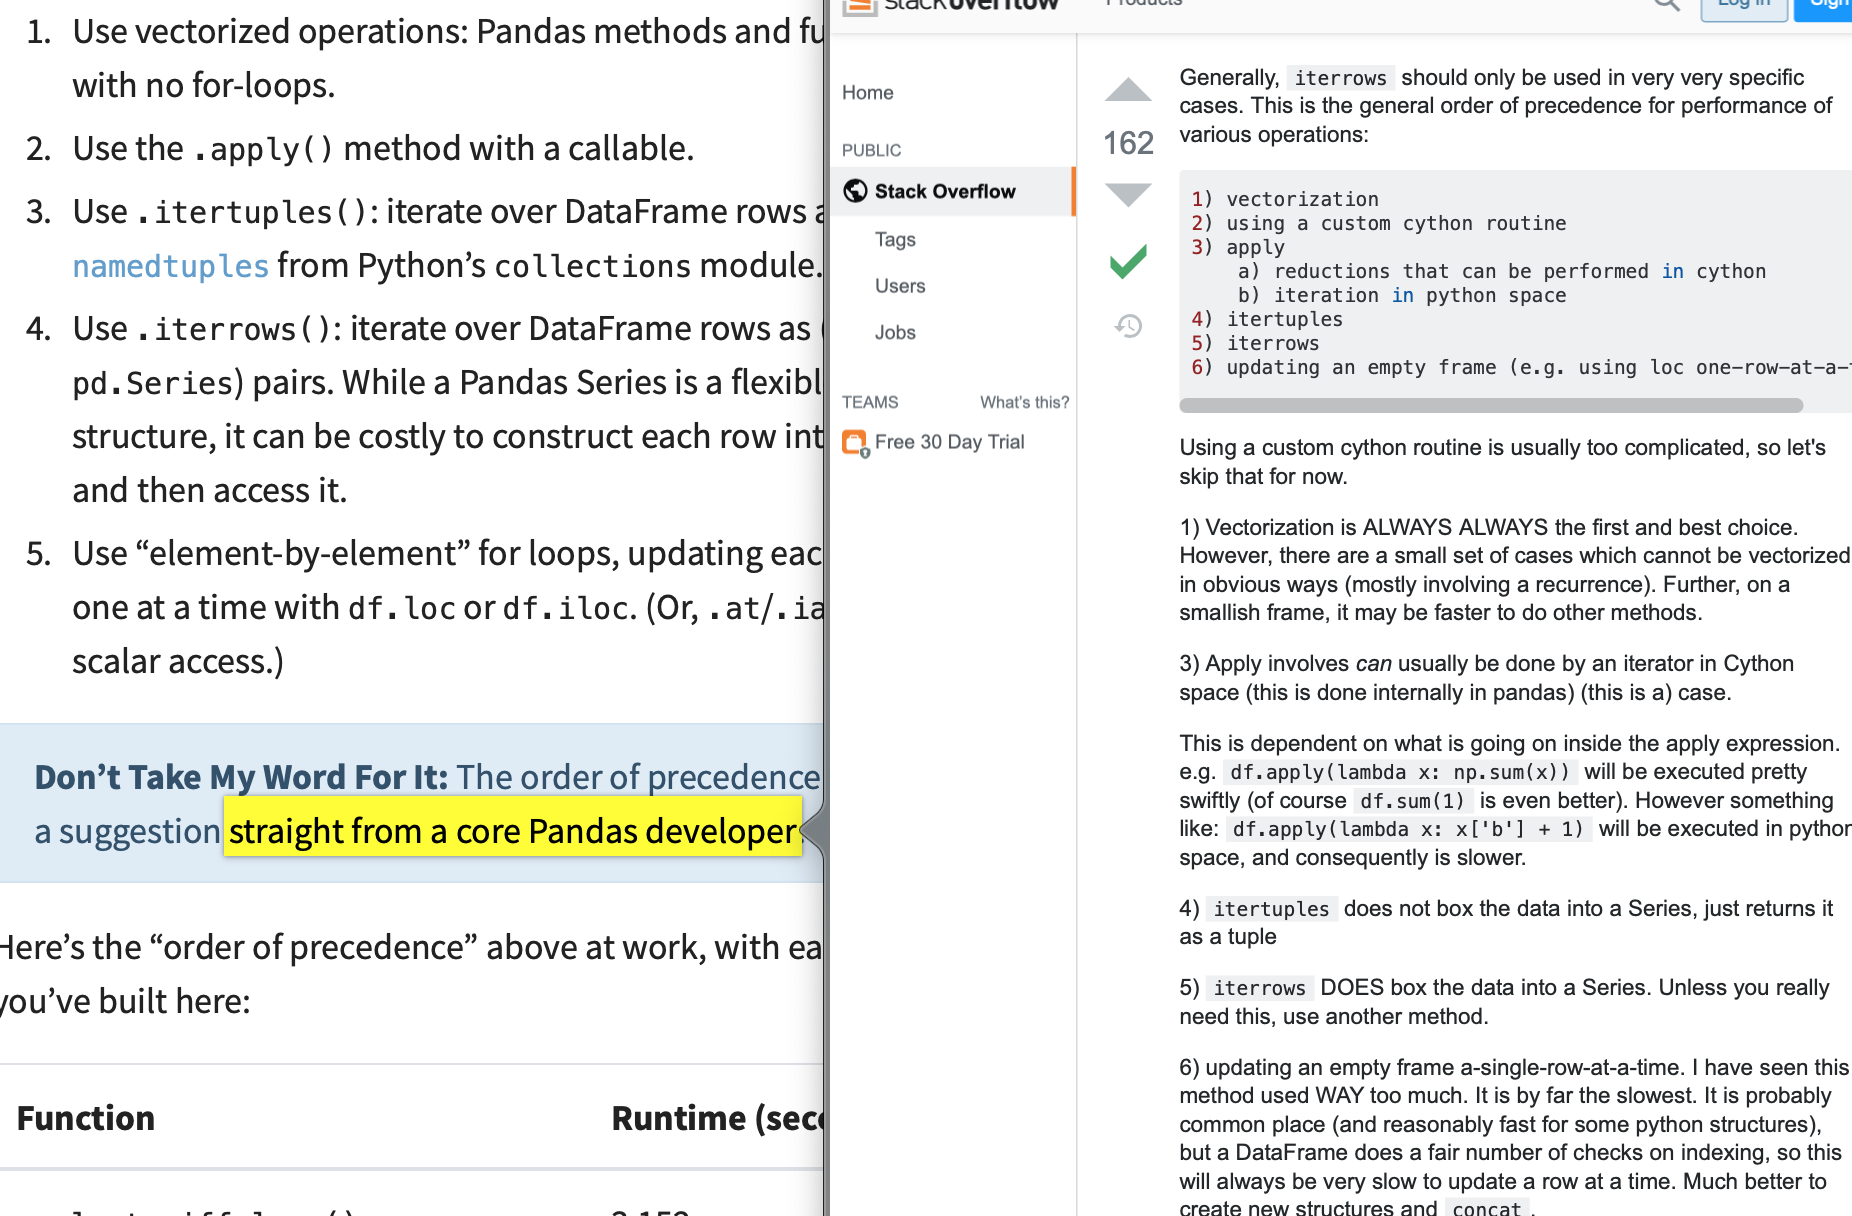